In [1]:
#Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from glob import glob
import PIL
import pydotplus
from IPython.display import display, Image
from sklearn.tree import export_graphviz

In [2]:
#Import pre-processed dataframe
ml_df = pd.read_csv('C:/datascience/springboard/projects/Venture Capital/data/Exported Data/ML Dataframe.csv', encoding="ISO-8859-1")

In [3]:
#Show summary information of Venture Capital Dataframe
ml_df.info(verbose=True)

#Set index to company name for reference (not a feature)
ml_df = ml_df.set_index('company_name')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20621 entries, 0 to 20620
Data columns (total 58 columns):
company_name         20621 non-null object
status               20621 non-null object
funding_rounds       20621 non-null float64
invscore_1           20621 non-null float64
invscore_10          20621 non-null float64
invscore_11          20621 non-null float64
invscore_12          20621 non-null float64
invscore_2           20621 non-null float64
invscore_3           20621 non-null float64
invscore_4           20621 non-null float64
invscore_5           20621 non-null float64
invscore_6           20621 non-null float64
invscore_7           20621 non-null float64
invscore_8           20621 non-null float64
invscore_9           20621 non-null float64
invct_1              20621 non-null float64
invct_10             20621 non-null float64
invct_11             20621 non-null float64
invct_12             20621 non-null float64
invct_2              20621 non-null float64
invct_3      

In [4]:
#Before Encoding print value_counts of each label (4)
print("Full Dataset Target Label Counts:", '\n', ml_df['status'].value_counts(), '\n')
print("Full Dataset Target as % of Total:", '\n', round(ml_df['status'].value_counts() / len(ml_df), 2), '\n')

#Convert df to array and perform one-hot encoding for target variable 'status'
tgt_enc = LabelEncoder().fit(ml_df['status'])
tgt_encoded = tgt_enc.transform(ml_df['status'])
ml_df = ml_df.drop(columns='status')

#Print Status Labels and Numbers for reference
print("Target Labels", np.unique(tgt_enc.inverse_transform(tgt_encoded)), '\n' ,"Label Numbers", np.unique(tgt_encoded))

Full Dataset Target Label Counts: 
 operating    15157
acquired      4567
closed         553
ipo            344
Name: status, dtype: int64 

Full Dataset Target as % of Total: 
 operating    0.74
acquired     0.22
closed       0.03
ipo          0.02
Name: status, dtype: float64 

Target Labels ['acquired' 'closed' 'ipo' 'operating'] 
 Label Numbers [0 1 2 3]


Given that 74% of the companies in the dataset are companies still operating, one strategy would be to just predict that every company is operating. This would result in 74% accuracy, therefore one of my criteria is to acheive an accuracy score of greater than 74% to be considered useful. 

In [5]:
#Convert dataframe to array and separate feature data (X) from target data (Y)
X = ml_df.values
Y = tgt_encoded

#Scale feature data to acheieve mean of zero for each feature to account for large variation of values
scaled_X = StandardScaler().fit_transform(X)

#Train, test, split data using 70% of data for training
X_train, X_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.4)

#Instantiate instance of RandomForestClassifier with default hyperparameters. Random_state preserves story in notebook.
model_feateng = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

#Train and create prediction values for training data. Using this only for feature selection.
model_feateng.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

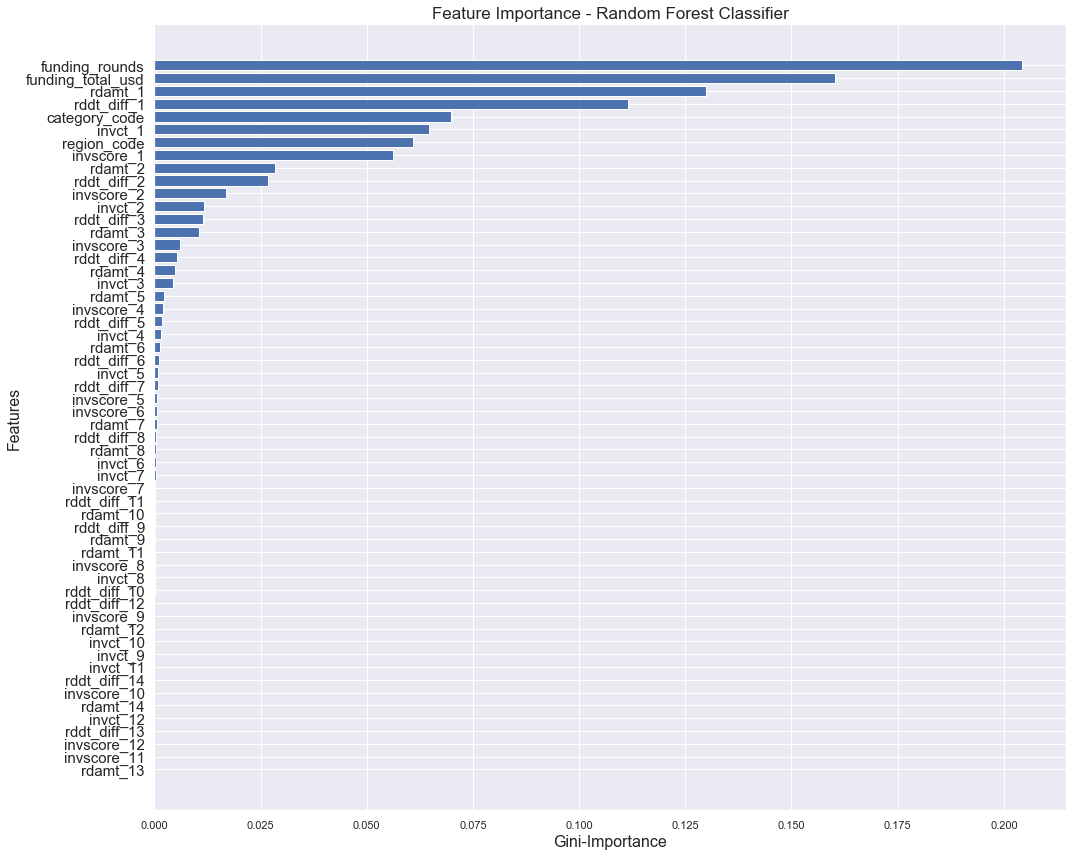

In [6]:
#Visualize feature importance
features_RandTree = {}

for feature, importance in zip(ml_df.columns, model_feateng.feature_importances_):
    features_RandTree[feature] = importance

importances_RandTree = pd.DataFrame.from_dict(features_RandTree, orient='index').rename(columns={0: 'Gini-Importance'})
importances_RandTree = importances_RandTree.sort_values(by='Gini-Importance', ascending=True)

fig, ax = plt.subplots(figsize=(15,12))
plt.barh(importances_RandTree.index, importances_RandTree['Gini-Importance'])
plt.title('Feature Importance - Random Forest Classifier', fontsize=17)
ax.set_ylabel('Features', fontsize=16)
ax.set_yticklabels(importances_RandTree.index, fontsize=15)
ax.set_xlabel('Gini-Importance', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
#Subset original training set using identified highest importance features (5% threshold)
sfm_RandTree = SelectFromModel(model_feateng, threshold=0.05)
sfm_RandTree.fit(X_train, y_train)

#Print and store selected features
selected_feat = []

for idx, feature_list_index in enumerate(sfm_RandTree.get_support(indices=True)):
    i = idx + 1
    print("Selected Feature %s:" % i, ml_df.columns[feature_list_index])
    selected_feat.append(ml_df.columns[feature_list_index])

#Transform data based on feature selection
X_important_train = sfm_RandTree.transform(X_train)
X_important_test = sfm_RandTree.transform(X_test)

Selected Feature 1: funding_rounds
Selected Feature 2: invscore_1
Selected Feature 3: invct_1
Selected Feature 4: rddt_diff_1
Selected Feature 5: rdamt_1
Selected Feature 6: funding_total_usd
Selected Feature 7: category_code
Selected Feature 8: region_code


In [13]:
#Perform Randomized and Grid Search Function for parameter tuning. 

#Parameter ranges (Estimators, Features, Depth, Samples_Split, Samples_Leaf, and Bootstrap)
#Number of Trees
n_estimators = [int(x) for x in np.linspace(start=10, stop=1000, num=30)]

#Number of features at each split
max_features = ['auto','sqrt']

#Max depth of each tree
max_depth = [int(x) for x in np.linspace(start=5, stop=100, num=20)]
max_depth.append(None)

#Min samples at each split
min_samples_split = [int(x) for x in np.linspace(start=2, stop=100, num=10)]

#Minimun samples at base leaf
min_samples_leaf = [int(x) for x in np.linspace(start=2, stop=100, num=10)]

#Method of selecting samples for training each tree
bootstrap = [True, False]

#Place all parameter ranges in grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#Instantiate instance of RandomForestClassifier
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, 
                               random_state=42, n_jobs=-1)

#Fit to training set with selected features. Don't fit in the example as it takes about 20min to run 
rf_random.fit(X_important_train, y_train)

#Here are the best params 
best_params= {'n_estimators': 283,
              'min_samples_split': 56,
              'min_samples_leaf': 67,
              'max_depth': None,
              'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.5min finished


In [14]:
#Instantiate GridSearchCV using range near best params of RandomizedSearch

param_grid = {
              'bootstrap': [True],
              'max_depth': [None],
              'max_features': ['auto'],
              'min_samples_leaf': [60, 67, 74],
              'min_samples_split': [50, 56, 62],
              'n_estimators': [100, 283, 500, 1000]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)  

# Fit the grid search to the data (Takes about 3min to run)
grid_search.fit(X_important_train, y_train)

#View results of grid_search
grid_search.best_params_
best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.4min finished


In [28]:
#Base Model Evaluation
base_model = RandomForestClassifier(n_estimators=10, random_state=4)
base_model.fit(X_important_train, y_train)
base_model_pred = base_model.predict(X_important_test)

#RandomizedSearch Tuned Model Evaluation 
tuned_model = RandomForestClassifier(**rf_random.best_params_, random_state=5)
tuned_model.fit(X_important_train, y_train)
tuned_model_pred = tuned_model.predict(X_important_test)

#Grid Search Tuned Model
best_grid.fit(X_important_train, y_train)
best_grid_pred = best_grid.predict(X_important_test)

#Train and create prediction values for full dataset to compare to selected features
tuned_model.fit(X_train, y_train)
tuned_model_pred_full = tuned_model.predict(X_test)

best_grid.fit(X_train, y_train)
best_grid_pred_full = best_grid.predict(X_test)

#Base Model Score versus Parameter tuned models
print("Base Model Accuracy Score: %s" % round(accuracy_score(y_test, base_model_pred),2))
print("Tuned Model Accuracy Score: %s" % round(accuracy_score(y_test, tuned_model_pred),2))
print("Tuned Model Accuracy Score - Full Dataset: %s" % round(accuracy_score(y_test, tuned_model_pred_full),2))
print("Best Grid Model Accuracy Score: %s" % round(accuracy_score(y_test, best_grid_pred),2))
print("Best Grid Model Accuracy Score - Full Dataset: %s" % round(accuracy_score(y_test, best_grid_pred_full),2))
print("Best RCV Parameters: %s", rf_random.best_params_)
print("Best GSCV Parameters: %s", best_grid)

Base Model Accuracy Score: 0.85
Tuned Model Accuracy Score: 0.88
Tuned Model Accuracy Score - Full Dataset: 0.88
Best Grid Model Accuracy Score: 0.88
Best Grid Model Accuracy Score - Full Dataset: 0.88
Best RCV Parameters: %s {'n_estimators': 829, 'min_samples_split': 56, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Best GSCV Parameters: %s RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=60, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


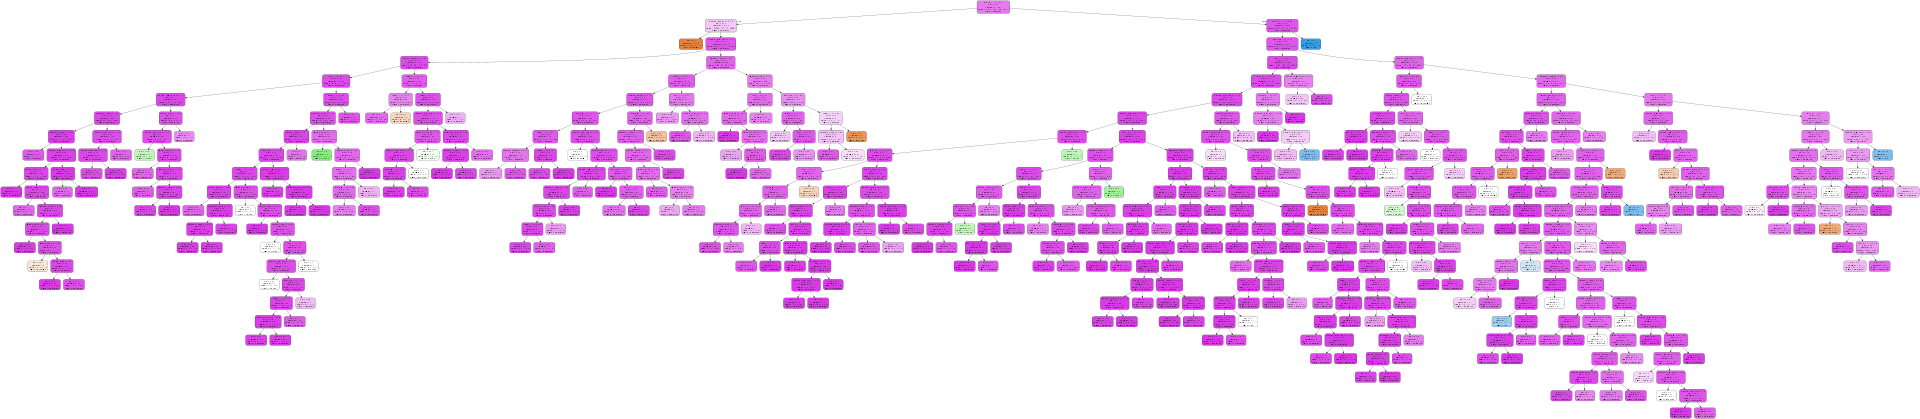

In [26]:
#Visualize Random Forest Trees
#Writes each decision tree to png file when called
def save_decision_trees_as_png(clf, iteration, feature_name, target_name):
    file_name = "vc_" + str(iteration) + ".png"
    dot_data = export_graphviz(
               clf,
               out_file=None,
               feature_names=feature_name,
               class_names=target_name,
               rounded=True,
               proportion=False,
               precision=2,
               filled=2,
    )
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.set_size('"20,20!"')
    graph.write_png(file_name)

feature_names = selected_feat
target_names = np.unique(tgt_enc.inverse_transform(tgt_encoded))
    
save_decision_trees_as_png(tuned_model.estimators_[0], i, feature_names, target_names)

#Place images in list for easier display
images = [ PIL.Image.open(f) for f in glob('./*.png') ]

#Display one of the n selected trees
display(Image(filename=images[0].filename, retina=True))

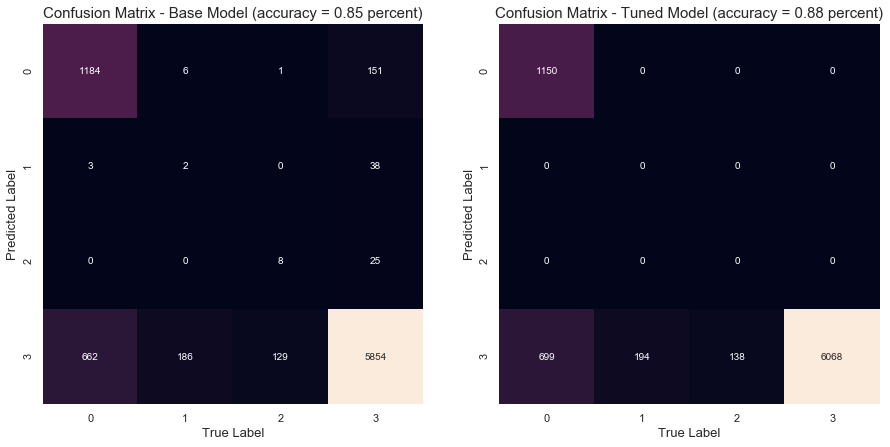

Target Labels ['acquired' 'closed' 'ipo' 'operating'] 
 Label Numbers [0 1 2 3]


In [29]:
#Graph confusion matrix for full dataset and dataset using top features
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
mat1 = confusion_matrix(y_test, base_model_pred)
mat2 = confusion_matrix(y_test, tuned_model_pred)

sns.heatmap(mat1.T, square=True, annot=True, fmt='d', cbar=False, ax=ax1)
ax1.set_title('Confusion Matrix - Base Model (accuracy = %s percent)' 
              % round(accuracy_score(y_test, base_model_pred),2), fontsize=15)
ax1.set_xlabel('True Label', fontsize=13)
ax1.set_ylabel('Predicted Label', fontsize=13)
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)

sns.heatmap(mat2.T, square=True, annot=True, fmt='d', cbar=False, ax=ax2)
ax2.set_title('Confusion Matrix - Tuned Model (accuracy = %s percent)' % 
              round(accuracy_score(y_test, tuned_model_pred),2), fontsize=15)
ax2.set_xlabel('True Label', fontsize=13)
ax2.set_ylabel('Predicted Label', fontsize=13)
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top- 0.5)

plt.show()

#Print Status Labels and Numbers for reference
print("Target Labels", np.unique(tgt_enc.inverse_transform(tgt_encoded)), '\n' ,"Label Numbers", np.unique(tgt_encoded))

In [30]:
#Classification Report
print("Random Forest - Base Model:" + '\n' + classification_report(y_test, base_model_pred, target_names=np.unique(tgt_enc.inverse_transform(tgt_encoded))))
print("Random Forest - Tuned Model:" + '\n' + classification_report(y_test, tuned_model_pred, target_names=np.unique(tgt_enc.inverse_transform(tgt_encoded))))

Random Forest - Base Model:
              precision    recall  f1-score   support

    acquired       0.88      0.64      0.74      1849
      closed       0.05      0.01      0.02       194
         ipo       0.24      0.06      0.09       138
   operating       0.86      0.96      0.91      6068

    accuracy                           0.85      8249
   macro avg       0.51      0.42      0.44      8249
weighted avg       0.83      0.85      0.84      8249

Random Forest - Tuned Model:
              precision    recall  f1-score   support

    acquired       1.00      0.62      0.77      1849
      closed       0.00      0.00      0.00       194
         ipo       0.00      0.00      0.00       138
   operating       0.85      1.00      0.92      6068

    accuracy                           0.88      8249
   macro avg       0.46      0.41      0.42      8249
weighted avg       0.85      0.88      0.85      8249



C:\Users\KKanoe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Takeaways

1) The Random Forest Model predicted approximately 62% of the acquired companies correctly (recall). Considering acquisitions comprised 22% of the original dataset, I consider this accuracy to be reasonably good.

2) Predicted results were given multi-class labels, but predictions were mostly binary. We likely don't have enough datapoints on companies that did an Initial Public Offering (IPO) or Closed. The tuned model distinguished between operating and acquired only, which was 96% of the original dataset. Interestingly, the base model picked up some of the IPO's and Closed companies. Overall, this would argue that the model would need to predict at least 50% of the acquisitions to be useful (i.e. binary classification).

3) The average weighted F1 score was 85%, which is useful for class imbalanced data such as this. 

4) The results were virtually identical regardless of if you used the three features or the full dataset. 

5) Tuning helped the model improve by about 3% from the base, but came at the price of added complexity as depicted by the image of a single decision tree. I also performed a 'eyeball' tuning test; visualizing max_depth, n_estimators, min_sample_split, and min_sample_leafs which was then used to tune a model. I was able to get similar results with less complexity (i.e. depth), which makes me question some of the parameters selected by the randomized cv search/grid search.

6) A question left unanswered that would ne helpful is, what sort of takeways could you get from the tree splits. Meaning, how many rounds = success or what's the typical funding total cutoff for success. You'd need to decrease the dept hof the tree and get a sense of this in order to answer these questions. But maybe there's a better way?

